In [23]:
!ls ..

!echo "------------------------------------"

!ls ../logs

!echo "------------------------------------"

!ls ../datasets/twitter/intermediate

bert_runner.py	datasets      notebooks		statistical_test.py
configurations	logs	      pretrained-model	statistical_tests
datahandlers	ml_runner.py  process.py	utils
datahelpers	models	      README.md
------------------------------------
 __init__.py			      twitter-evaluation-roberta.json   v1
'twitter-evaluation-(5-CV)-ml.json'   twitter-history-roberta.json
 twitter-evaluation-ml.json	      twitter_stats.json
------------------------------------
twitter_test.csv  twitter_train.csv  twitter_val.csv


In [24]:
import __init__
import json
import re
import random
import pandas as pd
import numpy as np
from datahandlers import DataReader
from sklearn.feature_extraction.text import TfidfVectorizer
random.seed(10)

tfidf = TfidfVectorizer(ngram_range=(2,4), sublinear_tf=True, analyzer='char')

def process_tweet(tweet):
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ", tweet.lower()).split())

In [25]:
test = DataReader.load_csv("../datasets/twitter/intermediate/twitter_test.csv")
test['processed_tweets'] = test['tweet'].apply(process_tweet)

train = DataReader.load_csv("../datasets/twitter/intermediate/twitter_train.csv")
train['processed_tweets'] = train['tweet'].apply(process_tweet)

display(test.head(2))

NgramLSVM_predicts = DataReader.load_json("../logs/twitter-evaluation-ml.json")
RoBERTa_predicts = DataReader.load_json("../logs/twitter-evaluation-roberta.json")

print(f"RoBERTa_predicts keys:{RoBERTa_predicts.keys()}")

# Train the same tfidf vectorize as the NgramLSVM used
tfidf.fit(train['processed_tweets'])

print(f"Size of Vocabulary: {len(tfidf.vocabulary_)}")

,tweet,label,processed_tweets
0,@user âmy mom says my smile is captivatingâ...,0,my mom says my smile is captivating i says hap...
1,"in 3 days i will be meeting my sis-n-law, coun...",0,in 3 days i will be meeting my sis n law coune...


RoBERTa_predicts keys:dict_keys(['Test-F1 Macro', 'Test-accuracy', 'Test-classification-report', 'Test-gt', 'Test-predict', 'Val-F1 Macro', 'Val-accuracy', 'Val-classification-report', 'Val-gt', 'Val-predict'])
Size of Vocabulary: 76484


In [26]:
gold = NgramLSVM_predicts['Test-gt']

clf1_pred_eval = [1 if gt == NgramLSVM_predicts['Test-predict'][i] else 0 for i, gt in enumerate(gold)]

clf2_pred_eval = [1 if gt == RoBERTa_predicts['Test-predict'][i] else 0 for i, gt in enumerate(gold)]

ngramlsvm_correct_roberta_wrong_ids = [i for i, _ in enumerate(clf1_pred_eval)
                                      if clf1_pred_eval[i] == 1 and clf2_pred_eval[i] == 0]

roberta_correct_ngramlsvm_wrong_ids = [i for i, _ in enumerate(clf1_pred_eval)
                                      if clf1_pred_eval[i] == 0 and clf2_pred_eval[i] == 1]

both_models_predict_wrong = [i for i, _ in enumerate(clf1_pred_eval)
                            if clf1_pred_eval[i] == 0 and clf2_pred_eval[i] == 0]

both_models_predict_correctly = [i for i, _ in enumerate(clf1_pred_eval)
                            if clf1_pred_eval[i] == 1 and clf2_pred_eval[i] == 1]


print(f"# of samples NgramLSVM predict correctly but RoBERTa predicts wrongly:"
      f"{len(ngramlsvm_correct_roberta_wrong_ids)}\n")

print(f"# of samples RoBERTa predict correctly but NgramLSVM predicts wrongly:"
      f"{len(roberta_correct_ngramlsvm_wrong_ids)}\n")

print(f"# both models predict wrongly:"
      f"{len(both_models_predict_wrong)}\n")

print(f"# both models predict correctly:"
      f"{len(both_models_predict_correctly)}")

# of samples NgramLSVM predict correctly but RoBERTa predicts wrongly:35

# of samples RoBERTa predict correctly but NgramLSVM predicts wrongly:166

# both models predict wrongly:58

# both models predict correctly:6134


In [5]:
# picking 10 first samples from each category for both classes for investigations
sample_no = 10

def get_random_samples(ids, sample_no):
    sample = random.sample(range(0, len(ids)), k=sample_no)
    return [ids[i] for i in sample]

def analysis(data):
    mtx = tfidf.transform(data['tweet'])
    scores = list(np.sum(mtx.toarray(), axis=1))
    counts = np.count_nonzero(mtx.toarray(), axis=1)
    data['tfidf-score'] = scores
    data['tfidf-token-counts'] = counts
    return data

def get_samples(data, ids, sample_no):
    select = get_random_samples(ids, sample_no)
    #print(select)
    df_data = {
        "tweet":[data['tweet'].tolist()[i] for i in select],
        "label":[data['label'].tolist()[i] for i in select],
        "processed_tweets":[data['processed_tweets'].tolist()[i] for i in select],
        "roberta-predict": [RoBERTa_predicts['Test-predict'][i] for i in select],
        "ngramlsvm-predict": [NgramLSVM_predicts['Test-predict'][i] for i in select],
    }
    df_data = analysis(df_data)
    return pd.DataFrame(df_data)

ngramlsvm_correct_roberta_wrong_samples = get_samples(test, ngramlsvm_correct_roberta_wrong_ids, sample_no=35)
roberta_correct_ngramlsvm_wrong_samples = get_samples(test, roberta_correct_ngramlsvm_wrong_ids, sample_no=166)
both_models_predict_wrong_samples = get_samples(test, both_models_predict_wrong, sample_no=58)
both_models_predict_correctly_samples = get_samples(test, both_models_predict_correctly, sample_no=6134)

In [6]:
ngramlsvm_correct_roberta_wrong_samples.head(3)

,tweet,label,processed_tweets,roberta-predict,ngramlsvm-predict,tfidf-score,tfidf-token-counts
0,white girls will never break the internet... ...,0,white girls will never break the internet,1,0,9.897643,113
1,the headline porays the mindset of the majorit...,0,the headline porays the mindset of the majorit...,1,0,11.897464,166
2,!!! no-balls to 'own' his ... 'coward' !!! ///,1,no balls to own his coward,0,1,6.166505,46


In [7]:
tfidf.idf_

array([ 5.63776449,  6.78289679,  9.82741923, ..., 10.23288434,
       10.23288434,  8.84658998])

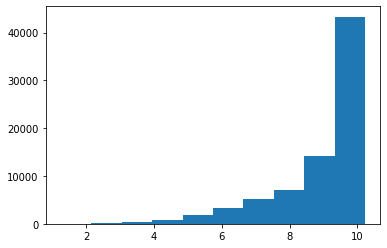

In [8]:
import matplotlib.pyplot as plt


# IDF histogram
plt.hist(tfidf.idf_.astype('float'))
plt.show()

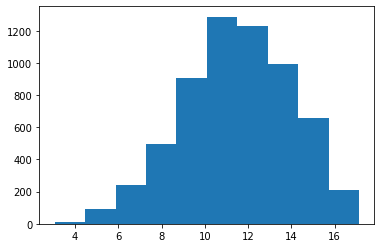

In [9]:
# Both models works well on the data
# both models predict correctly:6134

plt.hist(np.array(both_models_predict_correctly_samples['tfidf-score']).astype('float'))

plt.show()

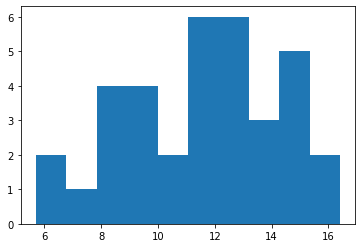

In [10]:
# of samples NgramLSVM predict correctly but RoBERTa predicts wrongly:35
plt.hist(np.array(ngramlsvm_correct_roberta_wrong_samples['tfidf-score']).astype('float'))

plt.show()

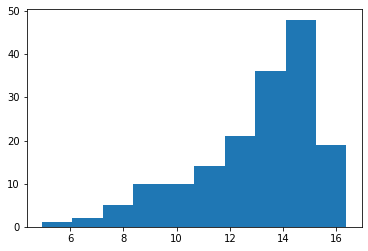

In [11]:
# of samples RoBERTa predict correctly but NgramLSVM predicts wrongly:166
plt.hist(np.array(roberta_correct_ngramlsvm_wrong_samples['tfidf-score']).astype('float'))

plt.show()

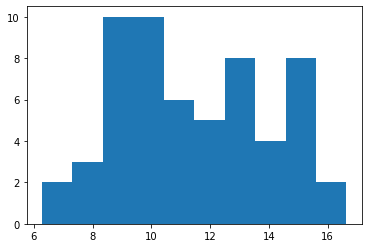

In [12]:
# both models predict wrongly:58
plt.hist(np.array(both_models_predict_wrong_samples['tfidf-score']).astype('float'))

plt.show()


In [16]:
ngramlsvm_correct_roberta_wrong_samples.to_excel("ngramlsvm_correct_roberta_wrong_samples.xlsx")
roberta_correct_ngramlsvm_wrong_samples.to_excel("roberta_correct_ngramlsvm_wrong_samples.xlsx")
both_models_predict_wrong_samples.to_excel("both_models_predict_wrong_samples.xlsx")
both_models_predict_correctly_samples.to_excel("both_models_predict_correctly_samples.xlsx")